#### Case Study: Cross-Sectional Factor Modeling

Cross-sectional factor modeling is a technique widely used in quantitative finance to explain and predict the returns of a broad set of securities (e.g., stocks) based on common underlying “factors.” 

A factor in this context can be a fundamental characteristic (e.g., valuation ratios, size), a technical feature (momentum, volatility), or a macroeconomic indicator (interest rates, inflation) that drives systematic risks and rewards.

This approach helps answer key questions:

* What drives the returns of different securities in a given universe?
* Which factors consistently earn premiums over time?
* How can we form portfolios that capture these factor premia and manage risk?

Below is a case study of a cross-sectional factor modeling exercise using Python. Although real-world applications use proprietary or market data (e.g., from Bloomberg or CRSP/Compustat), here we simulate data to illustrate the method.

/var/folders/ny/vjzzc9bn1cb7z1r685g0qbf80000gn/T/ipykernel_13532/1803270479.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(start='2015-01-01', periods=120, freq='M')


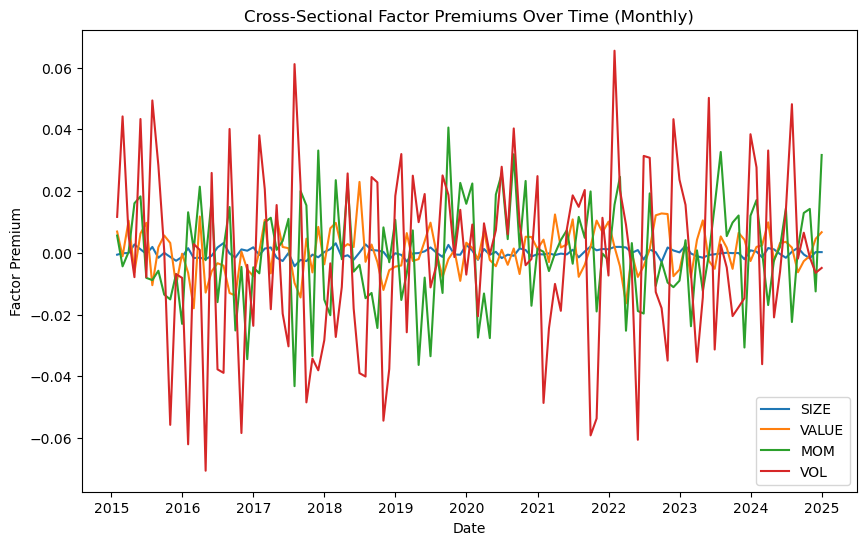

Average Factor Premiums:
Intercept        0.000956
SIZE_premium    -0.000079
VALUE_premium    0.000237
MOM_premium     -0.000201
VOL_premium     -0.001505
dtype: float64


In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

# 1. Data Simulation
# ----------------------------------------------------------------------
np.random.seed(42)

# Create 120 monthly periods (10 years of data), 1000 stocks
dates = pd.date_range(start='2015-01-01', periods=120, freq='M')
tickers = [f'Stock_{i}' for i in range(1000)]

# Simulate monthly returns (mean=0, std=0.05)
returns_data = np.random.normal(loc=0, scale=0.05, size=(120, 1000))

# Simulate factor exposures
# Let's assume 4 factors: SIZE, VALUE, MOM, VOL
size_factor = np.random.normal(10, 1, size=(120, 1000))   # e.g., log(MarketCap)
value_factor = np.random.normal(1, 0.2, size=(120, 1000)) # e.g., 1/PB
mom_factor = np.random.normal(0, 0.1, size=(120, 1000))   # e.g., 12-month momentum
vol_factor = np.random.normal(0.2, 0.05, size=(120, 1000))# e.g., volatility

# Combine into a single DataFrame
df_factors = []
for t, date in enumerate(dates):
    # For each monthly "snapshot," create a row per stock
    df_temp = pd.DataFrame({
        'Ticker': tickers,
        'Return': returns_data[t],
        'SIZE': size_factor[t],
        'VALUE': value_factor[t],
        'MOM': mom_factor[t],
        'VOL': vol_factor[t]
    })
    df_temp['Date'] = date
    df_factors.append(df_temp)

df_factors = pd.concat(df_factors, ignore_index=True)

# 2. Cross-Sectional Regression
# ----------------------------------------------------------------------
factor_premiums = []

# For each month, regress cross-sectional returns on the four factors
for date in df_factors['Date'].unique():
    # Slice the data for that date
    df_slice = df_factors[df_factors['Date'] == date].copy()
    
    # Dependent variable: stock returns in that month
    y = df_slice['Return']
    
    # Independent variables: factor exposures
    X = df_slice[['SIZE', 'VALUE', 'MOM', 'VOL']]
    X = sm.add_constant(X)  # add an intercept to the regression
    
    # Fit OLS model
    model = sm.OLS(y, X).fit()
    
    # Store factor premia
    factor_premiums.append({
        'Date': date,
        'Intercept': model.params['const'],
        'SIZE_premium': model.params['SIZE'],
        'VALUE_premium': model.params['VALUE'],
        'MOM_premium': model.params['MOM'],
        'VOL_premium': model.params['VOL']
    })

df_premiums = pd.DataFrame(factor_premiums).set_index('Date')

# 3. Analyze Factor Premia Over Time
# ----------------------------------------------------------------------
plt.figure(figsize=(10, 6))
plt.plot(df_premiums.index, df_premiums['SIZE_premium'], label='SIZE')
plt.plot(df_premiums.index, df_premiums['VALUE_premium'], label='VALUE')
plt.plot(df_premiums.index, df_premiums['MOM_premium'], label='MOM')
plt.plot(df_premiums.index, df_premiums['VOL_premium'], label='VOL')
plt.title('Cross-Sectional Factor Premiums Over Time (Monthly)')
plt.xlabel('Date')
plt.ylabel('Factor Premium')
plt.legend()
plt.show()

# Print average factor premia
avg_premiums = df_premiums.mean()
print("Average Factor Premiums:")
print(avg_premiums)